# Étude du lien entre les notes attribuées et la présence d'équipements

## I- Import des données

In [42]:
!pip install openpyxl
!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a
import pandas as pd
import requests
import io
import zipfile
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import os
import cartiflette.s3 as s3

  Cloning https://github.com/inseefrlab/cartiflette (to revision 80b8a5a28371feb6df31d55bcc2617948a5f9b1a) to /tmp/pip-req-build-3d2dsv7j
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-3d2dsv7j
  Running command git rev-parse -q --verify 'sha^80b8a5a28371feb6df31d55bcc2617948a5f9b1a'
  Running command git fetch -q https://github.com/inseefrlab/cartiflette 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Running command git checkout -q 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Resolved https://github.com/inseefrlab/cartiflette to commit 80b8a5a28371feb6df31d55bcc2617948a5f9b1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96

Nous commençons par télécharger les données relatives à divers équipements dans l'ensemble de la France, données issues de la base permanente des équipements (BPE) fournie par l'Insee.

In [6]:
# Reading the Zipfile with information about equipments in 2021
url = 'https://www.insee.fr/fr/statistiques/fichier/3568638/bpe21_ensemble_xy_csv.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# Two csv files are obtained

In [7]:
# Reading the file with information about equipments
dicType = {'BV2012': str, 'DCIRIS': str, 'DEP': str, 'DEPCOM': str, 'DOM': str, 'EPCI': str, 'SDOM': str}
BPE = pd.read_csv('bpe21_ensemble_xy.csv', sep=";", dtype = dicType)

Il est maintenant nécessaire de conserver uniquement les données concernant Paris pour le fichier qui nous intéresse, de manière à obtenir un fichier csv de taille plus raisonnable.

In [8]:
# Reducing the file to keep only Paris
with open('data/bpeParis.csv','w') as f:
    f = BPE.loc[BPE['DEP'] == '75']
    f.to_csv(path_or_buf = 'data/bpeParis.csv', index = False)

In [9]:
# We need to delete csv files that are too big to push
# i.e. bpe21_ensemble_xy.csv and Varmod_bpe21_ensemble_xy.csv
os.remove('bpe21_ensemble_xy.csv')
os.remove('Varmod_bpe21_ensemble_xy.csv')

## II- Traitement préliminaire pour associer les IRIS et les arrondissements

La base des équipements utilise le découpage territorial en IRIS, alors que les notes concernent les arrondissements. Pour obtenir des résultats sur les arrondissements, il convient donc d'associer chaque arrondissement aux IRIS qui le composent.

In [10]:
# Getting the file containing matchings between arrondissements and IRIS
url_1 = 'https://www.insee.fr/fr/statistiques/fichier/2017499/reference_IRIS_geo2023.zip'
r1 = requests.get(url_1)
z1 = zipfile.ZipFile(io.BytesIO(r1.content))
z1.extractall(path = 'data/')
Ref_IRIS = pd.read_excel('data/reference_IRIS_geo2023.xlsx')

In [11]:
# Changing the names of the columns
# It is only further in the excel file that we find the right column names
wrong_names = pd.Series.tolist(Ref_IRIS.columns)
col_names = pd.Series.tolist(Ref_IRIS.iloc[4])
dictionary_names = dict(zip(wrong_names, col_names))
Ref_IRIS = Ref_IRIS.rename(columns = dictionary_names)

# We obtain the right names of columns

In [12]:
# Obtaining a list with IRIS in the 1st arrondissement of Paris
Arr1 = Ref_IRIS[Ref_IRIS['LIBCOM'] == 'Paris 1er Arrondissement']
liste1 = pd.Series.tolist(Arr1['CODE_IRIS'])

In [13]:
#The same with all the other arrondissements
dicIRIS = {'Paris 1er Arrondissement': liste1}
for i in range(2,21):
    j = str(i)
    key_arr = 'Paris ' + j + 'e Arrondissement'
    Arr = Ref_IRIS[Ref_IRIS['LIBCOM'] == key_arr]
    val_arr = pd.Series.tolist(Arr['CODE_IRIS'])
    dicIRIS[key_arr] = val_arr

# We obtain a dictionary with the name of the arrondissement as a key 
# and a list with the numbers of IRIS corresponding as a value

Nous obtenons finalement un dictionnaire qui nous permet d'établir une correspondance entre les IRIS et les arrondissements.

## III- Étude des commerces

Nous nous intéressons ici à la catégorie B dans le fichier bpeParis.csv

### A- Préambule

Tout d'abord, il est nécessaire d'obtenir le nombre de commerces par arrondissement, en affinant selon le type de commerce.

In [14]:
dicType = {'BV2012': str, 'DCIRIS': str, 'DEP': str, 'DEPCOM': str, 'DOM': str, 'EPCI': str, 'SDOM': str}
BPE = pd.read_csv('data/bpeParis.csv', sep=",", dtype = dicType)

Nous prenons en considération les sous-domaines d'appartenance.

In [15]:
# Number of "Grandes surfaces" (B1) by arrondissement

# Concerning the 1st arrondissement of Paris
n1 = 0 # Number initialized
for iris in dicIRIS['Paris 1er Arrondissement']:
    col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'B1')]
    n1 += len(col) # number of lines

# Concerning the rest of the arrondissements
dicB1 = {'1er Arrondissement': n1}
n = 0
for i in range(2,21):
    key_arr = 'Paris ' + str(i) + 'e Arrondissement'
    for iris in dicIRIS[key_arr]:
        col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'B1')]
        n += len(col)
    dicB1[str(i) + 'e Arrondissement'] = n
    n = 0

# We obtain a dictionary with the name of the arrondissement as a key 
# and the number of "Grandes surfaces" as a value

In [16]:
# Number of "commerces alimentaires" (B2) by arrondissement

# Concerning the 1st arrondissement of Paris
n1 = 0 # Number initialized
for iris in dicIRIS['Paris 1er Arrondissement']:
    col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'B2')]
    n1 += len(col) # number of lines

# Concerning the rest of the arrondissements
dicB2 = {'1er Arrondissement': n1}
n = 0
for i in range(2,21):
    key_arr = 'Paris ' + str(i) + 'e Arrondissement'
    for iris in dicIRIS[key_arr]:
        col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'B2')]
        n += len(col)
    dicB2[str(i) + 'e Arrondissement'] = n
    n = 0

# We obtain a dictionary with the name of the arrondissement as a key 
# and the number of "commerces alimentaires" as a value

Nous créons maintenant un fichier csv pour isoler plus précisément les équipements selon leur type, et non plus seulement leur domaine ou leur sous-domaine.

In [19]:
# More precisely, we want to have the number of each type of equipments 
# whose field is B, i.e. "commerces", for each arrondissement
# To obtain this, we will create a csv file

# Concerning the 1st arrondissement of Paris
n1 = 0 # Number initialized
listType = ['B101', 'B102', 'B103', 'B201', 'B202', 'B203', 'B204', 'B205', 'B206', 'B301', 'B302', 'B303', 'B304', 'B305', 'B306', 'B307', 'B308', 'B309', 'B310', 'B311', 'B312', 'B313', 'B315', 'B316']
list1 = []
for type in listType:
    for iris in dicIRIS['Paris 1er Arrondissement']:
        col = BPE[(BPE['DCIRIS'] == iris) & (BPE['TYPEQU'] == type)]
        n1 += len(col) # number of lines
    list1.append(n1)
    n1 = 0

# Concerning the rest of the arrondissements
dicB = {'1er Arrondissement': list1}
n = 0
for arr in range(2,21):
    key_arr = 'Paris ' + str(arr) + 'e Arrondissement'
    listB_Type = []
    for type in listType:
        for iris in dicIRIS[key_arr]:
            col = BPE[(BPE['DCIRIS'] == iris) & (BPE['TYPEQU'] == type)]
            n += len(col)
        listB_Type.append(n)
        n = 0
    dicB[str(arr) + 'e Arrondissement'] = listB_Type

Commerces_precis = pd.DataFrame(dicB)
Commerces_precis.set_axis(listType, axis = 0)
Commerces_precis.to_csv(path_or_buf = 'data/Commerces.csv', index = False)

# Each row is one type of equipment, each column is an arrondissement

Prenons quelques exemples simples et descriptifs pour appréhender les données ainsi récupérées.

In [24]:
Commerces = pd.read_csv('data/Commerces.csv')
# Let's focus on bakeries (B203) in the 4th arrondissement
arr = '4e Arrondissement'
k = listType.index('B203') # Selecting the correct row
n = Commerces.loc[k, arr] # Selecting the number of bakeries in the 4th arrondissement
print("Il y a " + str(n) + " boulangeries dans le " + arr + ".")

Il y a 47 boulangeries dans le 4e Arrondissement.


In [26]:
# Let's see the mean of supermarkets (B102)
k = listType.index('B102')
n = Commerces.iloc[k].mean()
print("Il y a en moyenne " + str(n) + " supermarchés dans un arrondissement parisien.") 

Il y a en moyenne 29.6 supermarchés dans un arrondissement parisien.


### B- Régressions

Nous introduisons la variable sur laquelle les autres variables extraites précédemment vont être régressées, à savoir la note moyenne donnée par les habitants.

In [27]:
# Reading the excel file containing the grades obtained by each arrondissement in varied fields
# We only focus on the category 'Commerces'
Notes_arr = pd.read_excel('Notes_arrondissements.xlsx', decimal = ",")
notes = pd.Series(Notes_arr['Commerces'])
notes = pd.Series.tolist(notes)

Commerces = pd.read_csv('data/Commerces.csv')

#### 1) Régression en prenant comme variable le nombre de commerces

Concentrons-nous sur les commerces alimentaires.

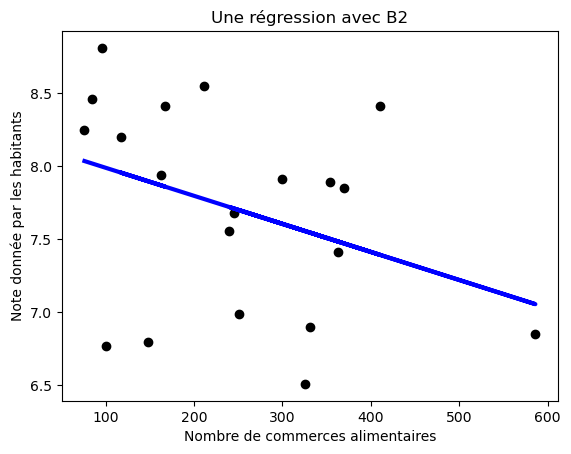

In [29]:
# Trying to make a regression with only B2
listB2 = pd.DataFrame(dicB2.values())
reg = LinearRegression().fit(listB2, notes)
y_pred = reg.predict(listB2)

plt.scatter(listB2, notes, color="black")
plt.plot(listB2, y_pred, color="blue", linewidth=3)
plt.xlabel('Nombre de commerces alimentaires')
plt.ylabel('Note donnée par les habitants')
plt.title('Une régression avec B2')
plt.show()

# Not very satisfactory since y_pred is surprisingly decreasing

Le résultat n'est pas très satisfaisant : on obtient une corrélation négative entre le nombre de commerces alimentaires et la note donnée par les habitants.

Coupons l'échantillon en deux pour éviter le surapprentissage.

In [30]:
# The same but by splitting the dataframe
# Split the data into training/testing sets
X_trainB2, X_testB2, y_trainB2, y_testB2 = sklearn.model_selection.train_test_split(listB2, notes, test_size = 0.5)

In [31]:
# Making a regression using the arrondissements in train
regB2 = LinearRegression().fit(X_trainB2, y_trainB2)

# Make predictions using the testing set
y_predB2 = regB2.predict(X_testB2)

In [32]:
# The coefficients
regB2.coef_

array([-0.00227621])

Là encore, la corrélation est négative.

In [43]:
regB2.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [33]:
regB2.score(X_testB2, y_testB2)

0.011844024745128134

Le R2 est très faible (inférieur à 0.05), ce qui semble que notre régression n'est pas très adaptée.

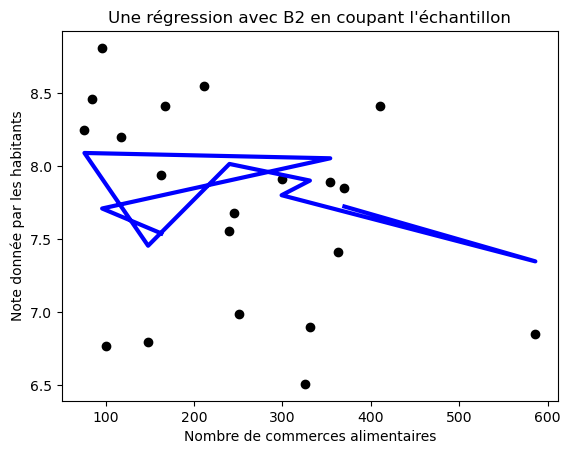

In [35]:
plt.scatter(listB2, notes, color="black")
plt.plot(X_trainB2, y_predB2, color="blue", linewidth=3)
plt.xlabel('Nombre de commerces alimentaires')
plt.ylabel('Note donnée par les habitants')
plt.title("Une régression avec B2 en coupant l'échantillon")
plt.show()

# Still not very satisfactory

On utilise les informations plus précises sur les différents types de commerces.

In [36]:
# Split the data into training/testing sets
Commerces2 = Commerces.transpose()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Commerces2, notes, test_size = 0.5)

In [37]:
# Making a regression using the arrondissements in train
reg = LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred = reg.predict(X_test)

In [38]:
# The coefficients
reg.coef_

array([-1.52340194e-03, -1.68979317e-02,  2.49362998e-04,  4.61169839e-03,
        7.81015655e-03, -4.58228878e-05, -6.21194992e-03,  5.81788778e-05,
        2.74692318e-03,  2.07988907e-02,  3.44583972e-03, -1.94625584e-02,
       -8.92844734e-03,  8.07568429e-03, -8.78946068e-03,  1.16654976e-02,
       -5.24547465e-03, -7.43495417e-04, -4.23650232e-03,  8.67892879e-03,
       -1.59968951e-02, -1.77144391e-03,  0.00000000e+00, -7.09235813e-03,
       -2.23113389e-03])

In [39]:
reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [40]:
# The R^2
reg.score(X_test, y_test)

-0.7768799871330252

Le R2 est négatif : notre modèle n'est absolument pas adapté. Il nous faut prendre en compte d'autres facteurs.

#### 2) Régression en prenant comme variable la densité des commerces

Tentons de prendre en compte la densité des équipements plutôt que leur nombre.

In [43]:
# Création d'une base de donnée associant pour chaque arrondissement sa superficie.

# Import des données géographiques des arrondissements parisiens depuis la librairie cartiflette
Arrondissements = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

# Stockage des superficies dans la series superficies
Arrondissements = Arrondissements.sort_values('INSEE_COG').reset_index()
superficies = Arrondissements.area
superficies

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE_ARRONDISSEMENT/crs=4326/DEPARTEMENT=75/vectorfile_format=topojson/provider=IGN/source=EXPRESS-COG-CARTO-TERRITOIRE/raw.topojson


Downloading: : 40.1kiB [00:00, 29.4MiB/s]
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed
/tmp/ipykernel_344/1247608674.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  superficies = Arrondissements.area


0     0.000224
1     0.000122
2     0.000143
3     0.000196
4     0.000312
5     0.000264
6     0.000501
7     0.000476
8     0.000267
9     0.000354
10    0.000447
11    0.002007
12    0.000874
13    0.000688
14    0.001038
15    0.002011
16    0.000695
17    0.000735
18    0.000832
19    0.000736
dtype: float64

In [46]:
pd.concat([Commerces, superficies.transpose()]) # :(
# NUL

,1er Arrondissement,2e Arrondissement,3e Arrondissement,4e Arrondissement,5e Arrondissement,6e Arrondissement,7e Arrondissement,8e Arrondissement,9e Arrondissement,10e Arrondissement,...,12e Arrondissement,13e Arrondissement,14e Arrondissement,15e Arrondissement,16e Arrondissement,17e Arrondissement,18e Arrondissement,19e Arrondissement,20e Arrondissement,0
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,3.0,2.0,1.0,0.0,0.0,2.0,NaN
1,6.0,8.0,5.0,9.0,16.0,15.0,17.0,20.0,26.0,28.0,...,30.0,48.0,36.0,62.0,40.0,47.0,43.0,44.0,49.0,NaN
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,4.0,2.0,2.0,7.0,2.0,1.0,5.0,5.0,2.0,NaN
3,8.0,10.0,7.0,9.0,10.0,8.0,11.0,14.0,18.0,25.0,...,17.0,19.0,15.0,20.0,22.0,33.0,25.0,29.0,18.0,NaN
4,20.0,27.0,36.0,30.0,64.0,30.0,39.0,61.0,84.0,157.0,...,99.0,79.0,75.0,140.0,80.0,140.0,307.0,140.0,161.0,NaN
5,38.0,33.0,43.0,47.0,66.0,58.0,73.0,65.0,75.0,84.0,...,124.0,96.0,99.0,170.0,94.0,128.0,143.0,93.0,120.0,NaN
6,6.0,10.0,3.0,11.0,17.0,14.0,18.0,16.0,23.0,46.0,...,43.0,39.0,38.0,60.0,37.0,46.0,84.0,57.0,54.0,NaN
7,4.0,2.0,4.0,0.0,6.0,4.0,4.0,3.0,5.0,7.0,...,8.0,9.0,8.0,15.0,7.0,11.0,9.0,7.0,8.0,NaN
8,0.0,2.0,3.0,3.0,4.0,3.0,3.0,4.0,6.0,7.0,...,8.0,3.0,5.0,5.0,11.0,12.0,18.0,5.0,2.0,NaN
9,44.0,38.0,27.0,46.0,94.0,100.0,52.0,78.0,81.0,79.0,...,88.0,57.0,67.0,96.0,67.0,73.0,56.0,46.0,39.0,NaN


In [44]:
NbLieux.to_frame().sort_values('CODE_POSTAL').reset_index()

NameError: name 'NbLieux' is not defined

In [ ]:
""" Copié sur Guilhem: à adapter !!!


# Ajout des données de superficie au dataframe contenant le nombre de lieux culturels par arrondissement.

NbLieux = NbLieux.to_frame().sort_values('CODE_POSTAL').reset_index()
NbLieux['superficie'] = superficies.values
NbLieux = NbLieux.rename(columns={'count':'nb_lieux'})


"""

In [ ]:
"""
# Création d'une colonne contenant les densités des lieux culturels 
NbLieux.nb_lieux = NbLieux.nb_lieux.astype('float64')
NbLieux['densite_culture'] = NbLieux.nb_lieux / NbLieux.superficie
"""

In [ ]:
"""

display(NbLieux.sort_values('densite_culture', ascending=False))

"""

In [ ]:
from cartiflette.s3 import download_vectorfile_url_all

'''Let's download the geographical data of Paris to create its map'''
Paris_borders = download_vectorfile_url_all(crs = 4326,values = ["75"],borders="COMMUNE_ARRONDISSEMENT",vectorfile_format="topojson",filter_by="DEPARTEMENT",source="EXPRESS-COG-CARTO-TERRITOIRE",year=2022)

## IV- Étude de l'enseignement

Nous nous intéressons ici à la catégorie C dans le fichier bpeParis.csv

In [47]:
# Number of "Lycées" (C3) by arrondissement

# Concerning the 1st arrondissement of Paris
n1 = 0 # Number initialized
for iris in dicIRIS['Paris 1er Arrondissement']:
    col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'C3')]
    n1 += len(col) # number of lines

# Concerning the rest of the arrondissements
dicC3 = {'1er Arrondissement': n1}
n = 0
for i in range(2,21):
    key_arr = 'Paris ' + str(i) + 'e Arrondissement'
    for iris in dicIRIS[key_arr]:
        col = BPE[(BPE['DCIRIS'] == iris) & (BPE['SDOM'] == 'C3')]
        n += len(col)
    dicC3[str(i) + 'e Arrondissement'] = n
    n = 0

# We obtain a dictionary with the name of the arrondissement as a key 
# and the number of "Lycées" as a value

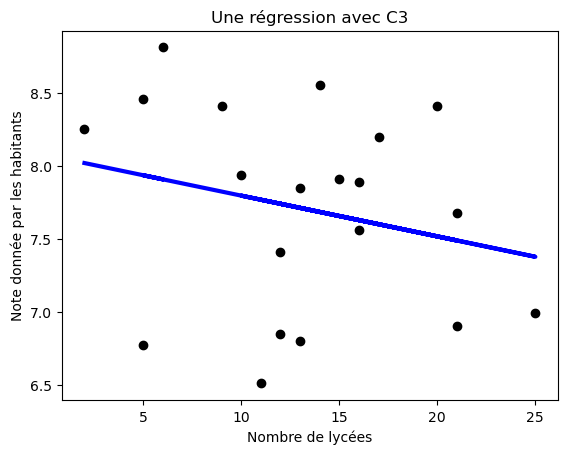

In [48]:
# Trying to make a regression with only C3
listC3 = pd.DataFrame(dicC3.values())
reg = LinearRegression().fit(listC3, notes)
y_pred = reg.predict(listC3)

plt.scatter(listC3, notes, color="black")
plt.plot(listC3, y_pred, color="blue", linewidth=3)
plt.xlabel('Nombre de lycées')
plt.ylabel('Note donnée par les habitants')
plt.title('Une régression avec C3')
plt.show()

In [ ]:
# More precisely, we want to have the number of each type of equipments whose field is B, i.e. "commerces", for each arrondissement
# To obtain this, we will create a csv file

# Concerning the 1st arrondissement of Paris
n1 = 0 # Number initialized
listType = ['C101', 'C102', 'C104', 'C105', 'C201', 'C301', 'C302', 'C303', 'C304', 'C305', 'C401', 'B307', 'B308', 'B309', 'B310', 'B311', 'B312', 'B313', 'B314', 'B315', 'B316']
##### Please find a list somewhere
list1 = []
for type in listType:
    for iris in dicIRIS['Paris 1er Arrondissement']:
        col = BPE[(BPE['DCIRIS'] == iris) & (BPE['TYPEQU'] == type)]
        n1 += len(col) # number of lines
    list1.append(n1)
    n1 = 0

# Concerning the rest of the arrondissements
dicB = {'1er Arrondissement': list1}
n = 0
for arr in range(2,21):
    key_arr = 'Paris ' + str(arr) + 'e Arrondissement'
    listBType = []
    for type in listType:
        for iris in dicIRIS[key_arr]:
            col = BPE[(BPE['DCIRIS'] == iris) & (BPE['TYPEQU'] == type)]
            n += len(col)
        listBType.append(n)
        n = 0
    dicB[str(arr) + 'e Arrondissement'] = listBType

Commerces_precis = pd.DataFrame(dicB)
Commerces_precis.set_axis(listType, axis = 0)
Commerces_precis.to_csv(path_or_buf = 'data/Commerces.csv', index = False)

# Each row is one type of equipment

## V- Étude de la santé

Nous nous intéressons ici à la catégorie D dans le fichier bpeParis.csv

## VI- Étude des transports

Nous nous intéressons ici à la catégorie E dans le fichier bpeParis.csv